In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from sklearn.cluster import MeanShift
from sklearn.ensemble import GradientBoostingClassifier as GBC

## Loading the data

Here we're loading a 1% subset of the NYC Taxi and Limousine commission data for 2013.

It is organized into trip data and fare data. The two files will need to be combined

In [2]:
DF = pd.read_csv("NYC_Taxi_2013_One_Percent_Trip.csv")
DF.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,1,N,3/8/2013 9:55:27 PM,3/8/2013 10:05:59 PM,2,631,2.5,-73.959610,40.715942,-73.963417,40.692169
1,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,1,N,3/9/2013 6:51:52 PM,3/9/2013 7:02:59 PM,2,666,1.8,-73.973373,40.763958,-73.977303,40.782139
2,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,1,N,3/9/2013 7:04:35 PM,3/9/2013 7:27:57 PM,2,1401,4.4,-73.977837,40.782818,-74.000893,40.737076
3,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,1,N,3/9/2013 8:33:06 PM,3/9/2013 8:45:38 PM,1,751,2.8,-73.980331,40.784382,-73.984291,40.748688
4,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,1,N,3/9/2013 11:10:38 PM,3/9/2013 11:14:59 PM,1,261,1.5,-73.986687,40.749474,-73.990677,40.762524


In [3]:
DF_Fare = pd.read_csv("NYC_Taxi_2013_One_Percent_Fare.csv")
DF_Fare.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,tip_amount
0,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,3/8/2013 9:55:27 PM,CSH,10.5,0.5,0.5,0.0,11.5,0.0
1,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,3/9/2013 6:51:52 PM,CRD,9.5,0.0,0.5,0.0,12.0,2.0
2,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,3/9/2013 7:04:35 PM,CSH,18.0,0.0,0.5,0.0,18.5,0.0
3,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,3/9/2013 8:33:06 PM,CSH,11.5,0.5,0.5,0.0,12.5,0.0
4,00005007A9F30E289E760362F69E4EAD,A9AE329EA1138052DAC8FDFD8BA86603,CMT,3/9/2013 11:10:38 PM,CRD,6.0,0.5,0.5,0.0,8.4,1.4


Next we will try to join these two datasets on medallion and pickup_datetime. Are these two enough to identify trips uniquelu?

In [4]:
print(DF_Fare["pickup_datetime"].count())
print(len(set(zip(DF_Fare["medallion"],DF_Fare["pickup_datetime"]))))

1703987
1703957


Not quite... but the count is small enough they can just be removed without much issue

In [5]:
DF_Fare_R = DF_Fare.set_index(["medallion","pickup_datetime"])
DF_R = DF.set_index(["medallion","pickup_datetime"])

DF_Full = DF_R.join(DF_Fare_R.drop(["hack_license","vendor_id"],axis=1))
DF_Full.head()

hack_license  \
medallion                        pickup_datetime                                           
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:17:59 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:30:26 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:55:40 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 11:12:02 PM  3FDE870B892182B43FC6AC68AC1F1950   

                                                       vendor_id  rate_code  \
medallion                        pickup_datetime                              
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM       CMT          1   
                                 10/1/2013 10:17:59 PM       CMT          1   
                                 10/1/2013 10:30:26 PM       CMT          1   
                                 10/1/2013 10:55:40 PM       CMT          1   
                                 10/1/2013 11:12:02 PM       CMT          1   

                                                       store_and_fwd_flag  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                N     
                                 10/1/2013 10:17:59 PM                N     
                                 10/1/2013 10:30:26 PM                N     
                                 10/1/2013 10:55:40 PM                N     
                                 10/1/2013 11:12:02 PM                N     

                                                             dropoff_datetime  \
medallion                        pickup_datetime                                
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  10/1/2013 10:14:40 PM   
                                 10/1/2013 10:17:59 PM  10/1/2013 10:22:51 PM   
                                 10/1/2013 10:30:26 PM  10/1/2013 10:45:33 PM   
                                 10/1/2013 10:55:40 PM  10/1/2013 11:07:29 PM   
                                 10/1/2013 11:12:02 PM  10/1/2013 11:19:51 PM   

                                                        passenger_count  \
medallion                        pickup_datetime                          
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                2   
                                 10/1/2013 10:17:59 PM                2   
                                 10/1/2013 10:30:26 PM                4   
                                 10/1/2013 10:55:40 PM                1   
                                 10/1/2013 11:12:02 PM                1   

                                                        trip_time_in_secs  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                425   
                                 10/1/2013 10:17:59 PM                291   
                                 10/1/2013 10:30:26 PM                907   
                                 10/1/2013 10:55:40 PM                709   
                                 10/1/2013 11:12:02 PM                468   

                                                        trip_distance  \
medallion                        pickup_datetime                        
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM            1.8   
                                 10/1/2013 10:17:59 PM            1.1   
                                 10/1/2013 10:30:26 PM            3.8   
                                 10/1/2013 10:55:40 PM            2.1   
                                 10/1/2013 11:12:02 PM            2.2   

                                                        pickup_longitude  \
medallion                        pickup_datetime                           
00005007A9F30E289E760362F69E4EAD 10/1/2

Just to see what happened with the duplicate entries

In [6]:
Dumset = DF_Fare[["medallion","pickup_datetime","hack_license"]].groupby(by=["medallion","pickup_datetime"]).count()
dupes = Dumset[Dumset["hack_license"]>1]
notdupes = Dumset[Dumset["hack_license"]<=1]

DF_Fare_R.loc[dupes.index.values]

hack_license  \
medallion                        pickup_datetime                                           
0067C755A2988CB8FA17AFCFE987B6A1 8/15/2013 3:54:00 PM   BBB738A4E3184BA6F3F4432142CC3EB4   
                                 8/15/2013 3:54:00 PM   BBB738A4E3184BA6F3F4432142CC3EB4   
1FEF6248184207A37D8269071CA74767 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
45C1242B0114EC24F7B2FD1EE1D40C5B 8/24/2013 9:36:00 PM   451EADA97AE37F3DFC14877BAFBC0C2A   
                                 8/24/2013 9:36:00 PM   451EADA97AE37F3DFC14877BAFBC0C2A   
4A970A1ED8FDCF0134F7379289C97B59 8/7/2013 7:26:00 AM    75BD96FACA1274FB9B517E75AC810B48   
                                 8/7/2013 7:26:00 AM    75BD96FACA1274FB9B517E75AC810B48   
4CC43843528FA98E05CF67FCEBA9C771 8/10/2013 1:11:00 PM   228CAA96F5435B771CC49979A15A1D6A   
                                 8/10/2013 1:11:00 PM   228CAA96F5435B771CC49979A15A1D6A   
500B99D0D2ED7D114701456891419249 4/28/2013 5:03:00 PM   291D2E3384398BC54D70B417AE2DD7A0   
                                 4/28/2013 5:03:00 PM   291D2E3384398BC54D70B417AE2DD7A0   
53796D7A77A1318785653D211B5B1F88 8/17/2013 5:20:00 AM   6D094F84AEB878169A91F8AF93BF0E2A   
                                 8/17/2013 5:20:00 AM   6D094F84AEB878169A91F8AF93BF0E2A   
62E545EBE4EA089C99BC640A37D15870 8/21/2013 1:39:00 PM   F955C3727B6D394FF1AB4548445560B1   
                                 8/21/2013 1:39:00 PM   F955C3727B6D394FF1AB4548445560B1   
6A4EB13F46065C70362E088C1E3D233E 8/5/2013 7:19:00 AM    1B3C3671A7EADE7DE4239D59BB374CDB   
                                 8/5/2013 7:19:00 AM    1B3C3671A7EADE7DE4239D59BB374CDB   
7C74981E275C409A06196D5BEF869403 8/7/2013 7:55:00 AM    D6206CD4B09EA994CDDDEE1A9CD4BFFA   
                                 8/7/2013 7:55:00 AM    D6206CD4B09EA994CDDDEE1A9CD4BFFA   
88D13BD5FFEB5C3CA0E69D24F8C009C0 8/9/2013 2:45:00 PM    DF63BCEE5786E3346759FAA7481A45D2   
                                 8/9/2013 2:45:00 PM    DF63BCEE5786E3346759FAA7481A45D2   
A0B0CBCF79CE29AFDE338A116EC7F9A9 4/25/2013 6:24:00 PM   6E2BA365B69B4B3E94487B41CAF9E713   
                                 4/25/2013 6:24:00 PM   6E2BA365B69B4B3E94487B41CAF9E713   
A33472E1BC4FDCA406658654C73280B7 8/30/2013 8:30:00 PM   D99D198395EC876497BBE06F1A26E954   
                                 8/30/2013 8:30:00 PM   D99D198395EC876497BBE06F1A26E954   
                                 8/30/2013 8:30:00 PM   D99D198395EC876497BBE06F1A26E954   
                                 8/30/2013 8:30:00 PM   D99D198395EC876497BBE06F1A26E954   
D2E6DAE1ADF7E83A3D49144125A13555 4/16/2013 2:22:00 PM   228E5F5E14DBA5ABF2B5DA36E707D09B   
                                 4/16/2013 2:22:00 PM   228E5F5E14DBA5ABF2B5DA36E707D09B   
D978FA187038016567511C9FDF2DB955 8/5/2013 1:55:00 PM    7B4B3A68E8CC41CEA47AAA2295A8E61E   
                                 8/5/2013 1:55:00 PM    7B4B3A68E8CC41CEA47AAA2295A8E61E   
DBA03C39ED8C744C7624D3E40E88893D 4/27/2013 9:11:00 AM   C069C625BEA9376E5A1D1BB7A58FBE90   
                                 4/27/2013 9:11:00 AM   C069C625BEA9376E5A1D1BB7A58FBE90   
                                 4/27/2013 9:11:00 AM   C069C625BEA9376E5A1D1BB7A58FBE90   
                                 4/27/2013 9:11:00 AM   C069C625BEA9376E5A1D1BB7A58FBE90   
DF7344AA3F7EB5F181F8702A46080992 8/19/2013 4:17:00 PM   07ADD0F28AFE2EE5553B4A9443079F0A   
                                 8/19/2013 4:17:00 PM   07ADD0F28AFE2EE5553B4A9443079F0A   
DF7BD80D956C5C9AC1765219E896951F 8/12/2013 2:29:00 PM   CE34DD8C9D9C4A661AEE132A1B5E7184   
                                 8/12/2013 2:29:00 PM   CE34DD8C9D9C4A661AEE132A1B5E7184   
E14C4326294C4D4212FCD9A9E914

In [7]:
DF_Full.loc[dupes.index.values]

hack_license  \
medallion                        pickup_datetime                                           
0067C755A2988CB8FA17AFCFE987B6A1 8/15/2013 3:54:00 PM   BBB738A4E3184BA6F3F4432142CC3EB4   
                                 8/15/2013 3:54:00 PM   BBB738A4E3184BA6F3F4432142CC3EB4   
                                 8/15/2013 3:54:00 PM   BBB738A4E3184BA6F3F4432142CC3EB4   
                                 8/15/2013 3:54:00 PM   BBB738A4E3184BA6F3F4432142CC3EB4   
1FEF6248184207A37D8269071CA74767 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
                                 8/22/2013 11:04:00 PM  F1E2ABEED88EFA7AB497AFC2FE69F0AF   
45C1242B0114EC24F7B2FD1EE1D40C5B 8/24/2013 9:36:00 PM   451EADA97AE37F3DFC14877BAFBC0C2A   
                                 8/24/2013 9:36:00 PM   451EADA97AE37F3DFC14877BAFBC0C2A   
                                 8/24/2013 9:36:00 PM   451EADA97AE37F3DFC14877BAFBC0C2A   
                                 8/24/2013 9:36:00 PM   451EADA97AE37F3DFC14877BAFBC0C2A   
4A970A1ED8FDCF0134F7379289C97B59 8/7/2013 7:26:00 AM    75BD96FACA1274FB9B517E75AC810B48   
                                 8/7/2013 7:26:00 AM    75BD96FACA1274FB9B517E75AC810B48   
                                 8/7/2013 7:26:00 AM    75BD96FACA1274FB9B517E75AC810B48   
                                 8/7/2013 7:26:00 AM    75BD96FACA1274FB9B517E75AC810B48   
4CC43843528FA98E05CF67FCEBA9C771 8/10/2013 1:11:00 PM   228CAA96F5435B771CC49979A15A1D6A   
                                 8/10/2013 1:11:00 PM   228CAA96F5435B771CC49979A15A1D6A   
...                                                                                  ...   
DF7344AA3F7EB5F181F8702A46080992 8/19/2013 4:17:00 PM   07ADD0F28AFE2EE5553B4A9443079F0A   
                                 8/19/2013 4:17:00 PM   07ADD0F28AFE2EE5553B4A9443079F0A   
DF7BD80D956C5C9AC1765219E896951F 8/12/2013 2:29:00 PM   CE34DD8C9D9C4A661AEE132A1B5E7184   
                                 8/12/2013 2:29:00 PM   CE34DD8C9D9C4A661AEE132A1B5E7184   
                                 8/12/2013 2:29:00 PM   CE34DD8C9D9C4A661AEE132A1B5E7184   
                                 8/12/2013 2:29:00 PM   CE34DD8C9D9C4A661AEE132A1B5E7184   
E14C4326294C4D4212FCD9A9E914F3EC 8/10/2013 9:32:00 PM   38E04E3AC63DBD4AB484ABF072710EE7   
                                 8/10/2013 9:32:00 PM   38E04E3AC63DBD4AB484ABF072710EE7   
                                 8/10/2013 9:32:00 PM   38E04E3AC63DBD4AB484ABF072710EE7   
                                 8/10/2013 9:32:00 PM   38E04E3AC63DBD4AB484ABF072710EE7   
E4C1A32129D41203F525A01198FEF96D 8/13/2013 1:11:00 PM   7CD473DFDA8EC6D5CC147424A85FBB7C   
                            

In [8]:
DF1 = DF_Full.loc[notdupes.index.values].copy()
print(DF_Full.shape[0])
print(DF1.shape[0])

1704065
1703933


The numbers aren't the same as would be expected if there were the same duplicated in both datasets. Perhaps there are some rows with N/A data

## Adding features
At present we wish to add a measure of

- The profitability of the feature set
- The hour of the day


In [9]:
PerMileCost = 0.592 #Cost per mile

#https://newsroom.aaa.com/tag/driving-cost-per-mile/
#Average sedan cost 59.2 cents

TimePenalty = 300 # Seconds to add to each trip to account for anything that needs to be done when the meter is not running
#Presently ad hoc

DF1["hourly_income_adjusted"] = 3600*(DF1["tip_amount"]+DF1["fare_amount"]-PerMileCost*DF1["trip_distance"])/DF1["trip_time_in_secs"]
DF1.head()

hack_license  \
medallion                        pickup_datetime                                           
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:17:59 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:30:26 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:55:40 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 11:12:02 PM  3FDE870B892182B43FC6AC68AC1F1950   

                                                       vendor_id  rate_code  \
medallion                        pickup_datetime                              
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM       CMT          1   
                                 10/1/2013 10:17:59 PM       CMT          1   
                                 10/1/2013 10:30:26 PM       CMT          1   
                                 10/1/2013 10:55:40 PM       CMT          1   
                                 10/1/2013 11:12:02 PM       CMT          1   

                                                       store_and_fwd_flag  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                N     
                                 10/1/2013 10:17:59 PM                N     
                                 10/1/2013 10:30:26 PM                N     
                                 10/1/2013 10:55:40 PM                N     
                                 10/1/2013 11:12:02 PM                N     

                                                             dropoff_datetime  \
medallion                        pickup_datetime                                
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  10/1/2013 10:14:40 PM   
                                 10/1/2013 10:17:59 PM  10/1/2013 10:22:51 PM   
                                 10/1/2013 10:30:26 PM  10/1/2013 10:45:33 PM   
                                 10/1/2013 10:55:40 PM  10/1/2013 11:07:29 PM   
                                 10/1/2013 11:12:02 PM  10/1/2013 11:19:51 PM   

                                                        passenger_count  \
medallion                        pickup_datetime                          
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                2   
                                 10/1/2013 10:17:59 PM                2   
                                 10/1/2013 10:30:26 PM                4   
                                 10/1/2013 10:55:40 PM                1   
                                 10/1/2013 11:12:02 PM                1   

                                                        trip_time_in_secs  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                425   
                                 10/1/2013 10:17:59 PM                291   
                                 10/1/2013 10:30:26 PM                907   
                                 10/1/2013 10:55:40 PM                709   
                                 10/1/2013 11:12:02 PM                468   

                                                        trip_distance  \
medallion                        pickup_datetime                        
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM            1.8   
                                 10/1/2013 10:17:59 PM            1.1   
                                 10/1/2013 10:30:26 PM            3.8   
                                 10/1/2013 10:55:40 PM            2.1   
                                 10/1/2013 11:12:02 PM            2.2   

                                                        pickup_longitude  \
medallion                        pickup_datetime                           
00005007A9F30E289E760362F69E4EAD 10/1/2

In [10]:
DF1['pickup_datetime'] = pd.to_datetime(np.array(list(DF1.index.values))[:,1])#This is really slow
DF1["hour"] = DF1["pickup_datetime"].apply(lambda l: l.hour)
DF1.head()


hack_license  \
medallion                        pickup_datetime                                           
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:17:59 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:30:26 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:55:40 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 11:12:02 PM  3FDE870B892182B43FC6AC68AC1F1950   

                                                       vendor_id  rate_code  \
medallion                        pickup_datetime                              
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM       CMT          1   
                                 10/1/2013 10:17:59 PM       CMT          1   
                                 10/1/2013 10:30:26 PM       CMT          1   
                                 10/1/2013 10:55:40 PM       CMT          1   
                                 10/1/2013 11:12:02 PM       CMT          1   

                                                       store_and_fwd_flag  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                N     
                                 10/1/2013 10:17:59 PM                N     
                                 10/1/2013 10:30:26 PM                N     
                                 10/1/2013 10:55:40 PM                N     
                                 10/1/2013 11:12:02 PM                N     

                                                             dropoff_datetime  \
medallion                        pickup_datetime                                
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  10/1/2013 10:14:40 PM   
                                 10/1/2013 10:17:59 PM  10/1/2013 10:22:51 PM   
                                 10/1/2013 10:30:26 PM  10/1/2013 10:45:33 PM   
                                 10/1/2013 10:55:40 PM  10/1/2013 11:07:29 PM   
                                 10/1/2013 11:12:02 PM  10/1/2013 11:19:51 PM   

                                                        passenger_count  \
medallion                        pickup_datetime                          
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                2   
                                 10/1/2013 10:17:59 PM                2   
                                 10/1/2013 10:30:26 PM                4   
                                 10/1/2013 10:55:40 PM                1   
                                 10/1/2013 11:12:02 PM                1   

                                                        trip_time_in_secs  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                425   
                                 10/1/2013 10:17:59 PM                291   
                                 10/1/2013 10:30:26 PM                907   
                                 10/1/2013 10:55:40 PM                709   
                                 10/1/2013 11:12:02 PM                468   

                                                        trip_distance  \
medallion                        pickup_datetime                        
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM            1.8   
                                 10/1/2013 10:17:59 PM            1.1   
                                 10/1/2013 10:30:26 PM            3.8   
                                 10/1/2013 10:55:40 PM            2.1   
                                 10/1/2013 11:12:02 PM            2.2   

                                                        pickup_longitude  \
medallion                        pickup_datetime                           
00005007A9F30E289E760362F69E4EAD 10/1/2

So one concern: there's probably a strong incentive for cab drivers to not report cash tips - since it would be extra effort and perhaps be subject to taxation. Do the rates of tipping differ between fares paid in cash and fares apid in credit?

In [11]:
set(DF1["payment_type"])

{'CRD', 'CSH', 'DIS', 'NOC', 'UNK'}

In [12]:
CashNoTip = np.sum(DF1[DF1["payment_type"]=="CSH"]["tip_amount"]==0)
CashTotalTrips = DF1[DF1["payment_type"]=="CSH"]["tip_amount"].count()
CashPercent = CashNoTip*100./CashTotalTrips
print("Out of {} trips:".format(CashTotalTrips))
print("{0:.2f}% of cash fares recorded no tip".format(CashPercent))


CredNoTip = np.sum(DF1[DF1["payment_type"]=="CRD"]["tip_amount"]==0)
CredTotalTrips = DF1[DF1["payment_type"]=="CRD"]["tip_amount"].count()
CredPercent = CredNoTip*100./CredTotalTrips
print("Out of {} trips:".format(CredTotalTrips))
print("{0:.2f}% of credit fares recorded no tip".format(CredPercent))

Out of 778153 trips:
99.99% of cash fares recorded no tip
Out of 918661 trips:
3.05% of credit fares recorded no tip


Pretty much no cash transactions bothered to record tips.

Since we're going to have a major bias for credit card trips paying more, we should actually use a metric that does not include tips.

In [13]:
DF1["hourly_income_adjusted"] = 3600*(DF1["fare_amount"]-PerMileCost*DF1["trip_distance"])/DF1["trip_time_in_secs"]
DF1.head() 

hack_license  \
medallion                        pickup_datetime                                           
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:17:59 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:30:26 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 10:55:40 PM  3FDE870B892182B43FC6AC68AC1F1950   
                                 10/1/2013 11:12:02 PM  3FDE870B892182B43FC6AC68AC1F1950   

                                                       vendor_id  rate_code  \
medallion                        pickup_datetime                              
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM       CMT          1   
                                 10/1/2013 10:17:59 PM       CMT          1   
                                 10/1/2013 10:30:26 PM       CMT          1   
                                 10/1/2013 10:55:40 PM       CMT          1   
                                 10/1/2013 11:12:02 PM       CMT          1   

                                                       store_and_fwd_flag  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                N     
                                 10/1/2013 10:17:59 PM                N     
                                 10/1/2013 10:30:26 PM                N     
                                 10/1/2013 10:55:40 PM                N     
                                 10/1/2013 11:12:02 PM                N     

                                                             dropoff_datetime  \
medallion                        pickup_datetime                                
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM  10/1/2013 10:14:40 PM   
                                 10/1/2013 10:17:59 PM  10/1/2013 10:22:51 PM   
                                 10/1/2013 10:30:26 PM  10/1/2013 10:45:33 PM   
                                 10/1/2013 10:55:40 PM  10/1/2013 11:07:29 PM   
                                 10/1/2013 11:12:02 PM  10/1/2013 11:19:51 PM   

                                                        passenger_count  \
medallion                        pickup_datetime                          
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                2   
                                 10/1/2013 10:17:59 PM                2   
                                 10/1/2013 10:30:26 PM                4   
                                 10/1/2013 10:55:40 PM                1   
                                 10/1/2013 11:12:02 PM                1   

                                                        trip_time_in_secs  \
medallion                        pickup_datetime                            
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM                425   
                                 10/1/2013 10:17:59 PM                291   
                                 10/1/2013 10:30:26 PM                907   
                                 10/1/2013 10:55:40 PM                709   
                                 10/1/2013 11:12:02 PM                468   

                                                        trip_distance  \
medallion                        pickup_datetime                        
00005007A9F30E289E760362F69E4EAD 10/1/2013 10:07:35 PM            1.8   
                                 10/1/2013 10:17:59 PM            1.1   
                                 10/1/2013 10:30:26 PM            3.8   
                                 10/1/2013 10:55:40 PM            2.1   
                                 10/1/2013 11:12:02 PM            2.2   

                                                        pickup_longitude  \
medallion                        pickup_datetime                           
00005007A9F30E289E760362F69E4EAD 10/1/2

In [14]:
#Other cells overwrite DF1, here it can be saved for backup so the whole dataset doesn't have to be reloaded.
DF_Saved = DF1.copy()

In [15]:
#Reload
DF1 = DF_Saved.copy()

## Now to Clean the data

In addition to random, wild points, some of the lat/lon pickup data has been switched. This will be fixed.

(the dropoff probably has the same problem - but here we focus on pickup data)

Text(0.5,1,'Raw pickup location data')

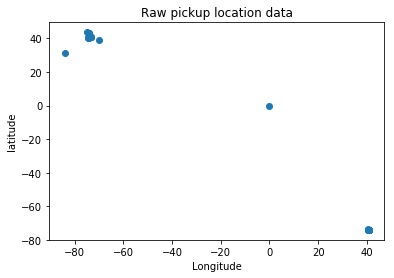

In [16]:
DF_Subset = DF1.sample(n=100000,random_state =765442)
plt.scatter(DF_Subset["pickup_longitude"],DF_Subset["pickup_latitude"])
plt.xlabel("Longitude")
plt.ylabel("latitude")
plt.title("Raw pickup location data")

In [17]:
Fixed_Pickup_Lon = np.minimum(DF1["pickup_longitude"].values,DF1["pickup_latitude"].values)
Fixed_Pickup_Lat = np.maximum(DF1["pickup_longitude"].values,DF1["pickup_latitude"].values)

DF1["pickup_latitude"] = Fixed_Pickup_Lat
DF1["pickup_longitude"] = Fixed_Pickup_Lon

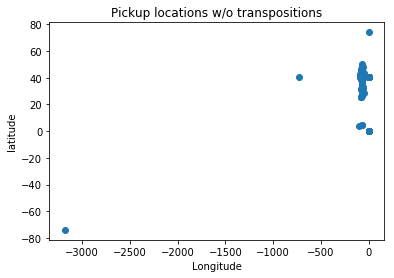

In [18]:
plt.scatter(DF1["pickup_longitude"],DF1["pickup_latitude"])
plt.xlabel("Longitude")
plt.ylabel("latitude")
plt.title("Pickup locations w/o transpositions")


plt.show()

There are still a lot of wild points... so we need to restrict the data to the actual area around New York City

In [19]:
#LatMin = 40.68
LatMin = 40.65
#LatMax = 40.82
LatMax = 40.84
LonMin = -74.05
#LonMax = -73.85
#LonMax = -73.80
LonMax = -73.75

Text(0.5,1,'Hourly Income, Raw')

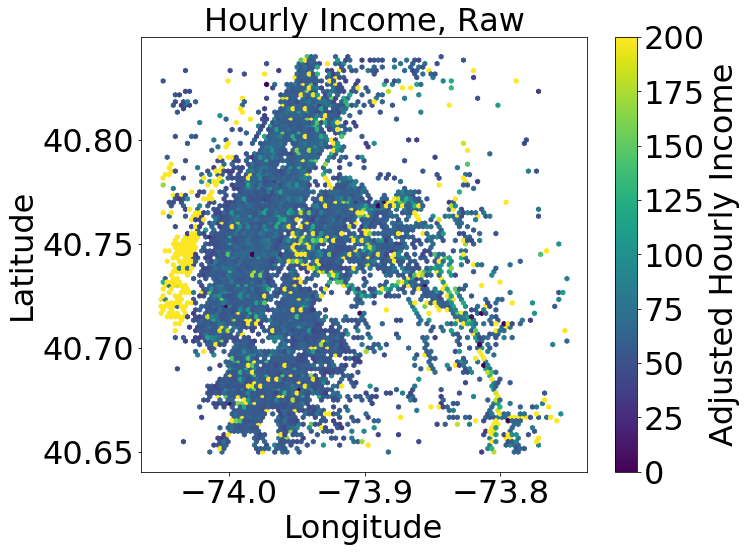

In [20]:
plt.figure(figsize=(10,8))
DF_Mask = np.logical_and(
    np.logical_and(DF1["pickup_latitude"]>LatMin, DF1["pickup_latitude"]<LatMax),
    np.logical_and(DF1["pickup_longitude"]>LonMin,DF1["pickup_longitude"]<LonMax)
)
DF1 = DF1[DF_Mask].copy()


SMALL_SIZE = 32
MEDIUM_SIZE = 32

plt.rc('font',weight='normal')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*0.8)    # legend fontsize

plt.hexbin(DF1["pickup_longitude"],DF1["pickup_latitude"],C=DF1["hourly_income_adjusted"],vmin=0,vmax=200)

c = plt.colorbar(label="Adjusted Hourly Income")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Hourly Income, Raw")

There is still a lot of variation including some points at 0.. this is probably due to very erroneous numbers.

Let's confine trip length and time to reasonable numbers

In [21]:
Mask = np.logical_and(
    np.logical_and(
        DF1["trip_time_in_secs"] > 60,
        DF1["trip_time_in_secs"] < 36000
    ),
    np.logical_and(
        DF1["trip_distance"] > 0.01,
        DF1["trip_distance"] < 200
    )
)
DF1 = DF1[Mask].copy()

Text(0.5,1,'Hourly Income, Cleaned')

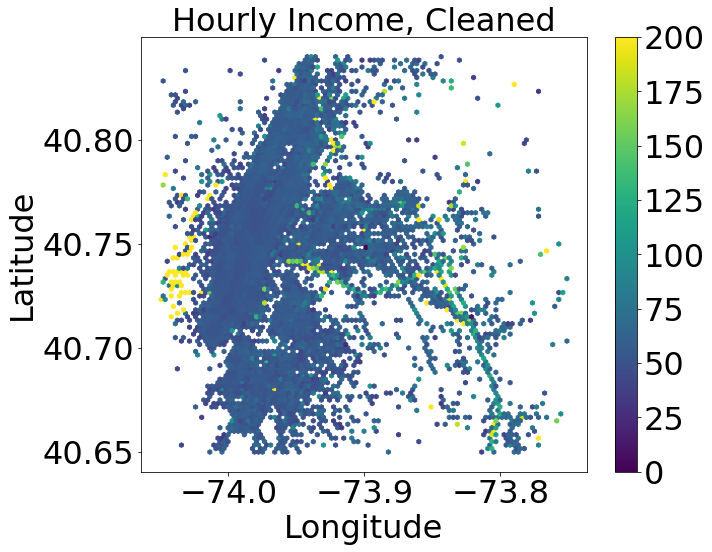

In [22]:
plt.figure(figsize=(10,8))
plt.hexbin(DF1["pickup_longitude"],DF1["pickup_latitude"],C=DF1["hourly_income_adjusted"],vmin=0,vmax=200)
#plt.axis([-74.05,-73.85,40.68,40.82])
c = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Hourly Income, Cleaned")

This does remove a lot of the spikes in the data

## Get a training set

In [23]:
DF_Train = DF1.sample(frac=0.1,random_state = 388495) #Tiny bit at first for testing

## Finding regions of high value

### Using clustering on high value rides

In [24]:
Threshold = 100

Mask = DF_Train["hourly_income_adjusted"] > Threshold
DF_Masked = DF_Train[Mask]

In [25]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20

plt.rc('font',weight='normal')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*0.8)    # legend fontsize

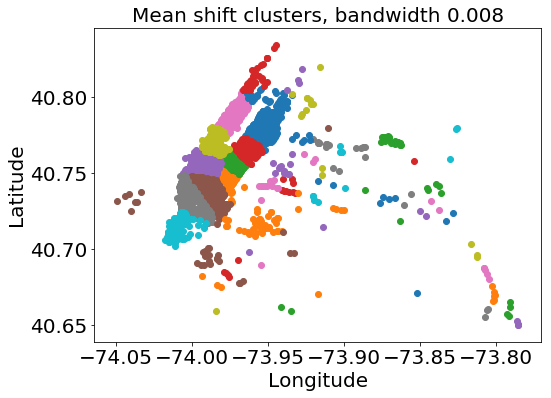

In [26]:
plt.figure(figsize=[8,6])
bw = 0.008
X = DF_Masked[["pickup_longitude","pickup_latitude"]]
MeanModel = MeanShift(bandwidth=bw)
labels_mean = MeanModel.fit_predict(X)

LabelList = list(set(labels_mean))
LabelList.sort()

for lbl in LabelList:
    CurrentPts = X[labels_mean==lbl]
    plt.scatter(CurrentPts["pickup_longitude"],CurrentPts["pickup_latitude"])
plt.gca().set_aspect(1)

plt.title("")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mean shift clusters, bandwidth {0}".format(bw))
plt.show()

Before doing anything too complicated programming intensive. I'm going to try throwing a machine learning classifier at it and see what comes out. In this case, a gradient boosted classifier.

In [27]:
X_temp = DF_Train[["pickup_longitude","pickup_latitude","hour"]]

Threshold = 60
y_temp = DF_Train[["hourly_income_adjusted","hour"]].copy()
y_temp["high_income"] = np.greater(y_temp["hourly_income_adjusted"],Threshold)*1

GBCModelList = []

for hour in range(0,24):
    X = X_temp[X_temp["hour"]==hour].drop("hour", axis=1)
    y = y_temp[y_temp["hour"]==hour]["high_income"]
    Model = GBC()
    Model.fit(X,y)
    GBCModelList.append(Model)

In [28]:
X_temp.values.shape

(165680, 3)

In [29]:
xx = np.linspace(LonMin,LonMax, num=100)
yy = np.linspace(LatMin,LatMax, num = 100)
X1, X2 = np.meshgrid(xx,yy,)
X = np.vstack([
    X1.reshape([np.product(X1.shape)]),
X2.reshape([np.product(X2.shape)])
]).T
print(X.shape)

(10000, 2)


In [30]:
def ColumnToArray(L,dims):
    return L.reshape(1,-1).reshape([dims[0],dims[1]])
    

In [31]:
#Check to make sure things get put back the right way
X1p = ColumnToArray(X[:,0],X1.shape)
np.all(X1p == X1)

True

Here is the result for the 11 am GBC model

Text(0,0.5,'Latitude')

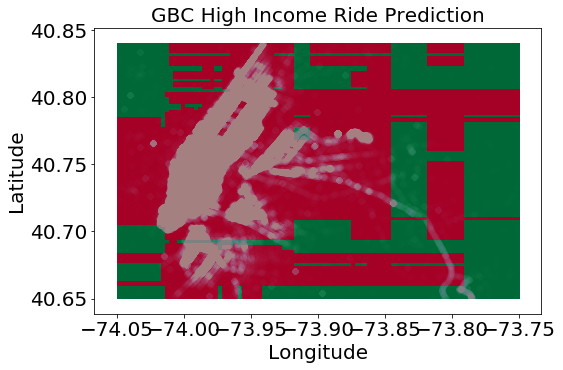

In [32]:
plt.figure(figsize=[8,6])

y_predict = GBCModelList[11].predict(X)
Y = ColumnToArray(y_predict,X1.shape)
plt.imshow(Y,extent=(LonMin,LonMax,LatMin,LatMax),origin="lower",cmap="RdYlGn")
plt.scatter(DF1["pickup_longitude"],DF1["pickup_latitude"],alpha=0.009,c='w')
#plt.gca().set_aspect(1)
plt.title("GBC High Income Ride Prediction")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

A lot of the structure of good versus bad is in areas with a minimal number of points. Obviously this is not a very good first try and we're not really fitting to the bulk of the data at all with this method, and that might be something that's hard to overcome by tweaking aprameters. So I'm going to proceed with trying something a little more complicated.

## This Approach

- Divide the city into regions/clusters
- Weed out clusters with too few points or too low of a ride density
- For each hour of the day, rank the remaining clusters

We already have a basic clustering algorithm that works to a simple extent, though likely it could be improved later. So the next step is to assess the ride density so we can weed out low traffic areas.

Assess ride density
- Find "area" of cluster using the square of average distance

- Find number of rides in cluster

- Assign a ride density minimum

- Weed out areas below a minimum number of rides from consideration

In [33]:
X = DF_Masked[["pickup_longitude","pickup_latitude"]]
MinRides = 20 #Minimum number of rides in a cluster to do counting on

MajorLabels = []
RideDensities = []

for lbl in LabelList:
    CurrentPts = X[labels_mean==lbl]
    Centroid = MeanModel.cluster_centers_[lbl]
    
    AvgDist = np.mean(
        np.sqrt(
            np.sum((CurrentPts-Centroid)**2,axis=1)
        )
    )

    AreaWeight = (AvgDist*100)**2 #The 100 is just to make the units come out closer to 1, could maybe use real units?
    #Also ignoring curature of the Earth

    
    # Do we have enough points?
    RideCount = CurrentPts.values.shape[0]
    
    if RideCount >= MinRides:
        MajorLabels.append(lbl)
        
        # What is the ride density? Make a list
        RideDensity = RideCount/AreaWeight
        RideDensities.append(RideDensity)



In [34]:
DensityDict = {}
for i, d in enumerate(RideDensities):
    DensityDict[MajorLabels[i]] = d 

DensityList = list(zip(MajorLabels,RideDensities))
SortedDensityList = sorted(DensityList,key=lambda l: l[1],reverse=True)
for i in range(0,len(SortedDensityList)):
    print(SortedDensityList[i])

(0, 1417.0584550666492)
(1, 1224.440488777374)
(2, 1110.2095268299972)
(3, 1039.4392366349662)
(4, 930.9770054840398)
(5, 669.6626522944829)
(8, 555.9936590989827)
(7, 442.6614413895194)
(6, 437.0803962185948)
(9, 216.25318261942084)
(12, 131.83037845697584)
(10, 105.72024335033424)
(11, 65.72692405612533)
(23, 17.33144359168452)


So, traim a classifier that predicts the top N income earning areas above a ride density threshold

In [35]:
DensityThreshold = 800 #Looking at the data, this seems to cull at a good point:
#where the dropoff is steep
Mask = [l[1]>DensityThreshold for l in SortedDensityList]
HighDensityLabels = np.array([l[0] for l in SortedDensityList])[Mask]

IncomeList = []
X = DF_Train[["pickup_longitude","pickup_latitude"]]
y = DF_Train["hourly_income_adjusted"]

TrainLabels = MeanModel.predict(X)

for lbl in HighDensityLabels:
    Income = y[TrainLabels==lbl].mean()
    IncomeList.append(Income)
    print(Income, lbl)
    

56.83277807865953 0
54.86683980708363 1
53.35405312915699 2
55.22205073605711 3
53.240284107942664 4


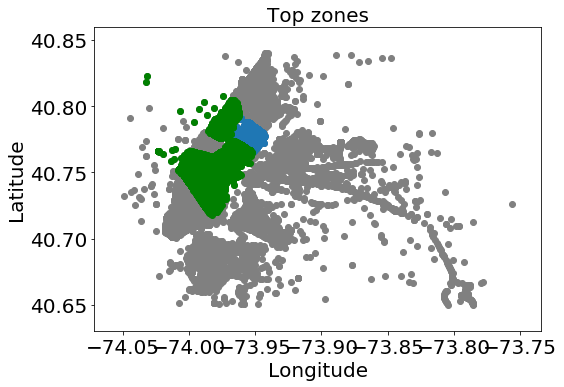

In [36]:
plt.figure(figsize = [8,6])

plt.scatter(X["pickup_longitude"],X["pickup_latitude"], color='gray')
X_sub = X[TrainLabels==0]
plt.scatter(X_sub["pickup_longitude"],X_sub["pickup_latitude"])
for i in range(1,7):
    X_sub = X[TrainLabels==i]
    plt.scatter(X_sub["pickup_longitude"],X_sub["pickup_latitude"],color = 'green')
plt.title("Top zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.gca().set_aspect(1)

Here the blue zone is the highest profit zone, and the green are the others in the same league.

Now, test it on some data

Lets do this as a class with methods and fit a model


In [37]:
class CityZone:
    def __init__(self, hour=None):
        self.hour = hour
        return
    
    def MakeZones(self,DF,IncomeThreshold, bw = 0.008,plot=False):
        """Given a list of points and a threshold, divide the city up into zones with clustering"""
        
        self.Mask = DF["hourly_income_adjusted"] > IncomeThreshold
        DF_Masked = DF[self.Mask]
        
        X = DF_Masked[["pickup_longitude","pickup_latitude"]]
        y = DF_Masked["hourly_income_adjusted"]
        
        self.MeanModel = MeanShift(bandwidth=bw)
        self.labels_mean = self.MeanModel.fit_predict(X)

        self.LabelList = list(set(self.labels_mean))
        self.LabelList.sort()
        
        if plot:
            for lbl in LabelList:
                CurrentPts = X[self.labels_mean==lbl]
                plt.scatter(CurrentPts["pickup_longitude"],CurrentPts["pickup_latitude"])
            plt.show()

        return self.labels_mean, self.LabelList
    
    def RankZones(self,DF, DensityThreshold, MinRides = 20, Top = 3):
        """Returns a list of top earning clusters above a cdensity threshold"""
        
        X = DF[["pickup_longitude","pickup_latitude"]]
        y = DF["hourly_income_adjusted"]
        
        L = self.MeanModel.predict(X) #Will fail if X is length 0. make a try workaround?
        
        
        RideDensities = []
        MajorLabels = []        
        
        for lbl in self.LabelList:
            CurrentPts = X[L==lbl]
            Centroid = self.MeanModel.cluster_centers_[lbl]
            AvgDist = np.mean(
                np.sqrt(
                    np.sum((CurrentPts-Centroid)**2,axis=1)
                )
            )
            AreaWeight = (AvgDist*100)**2 #The 100 is just to make the units come out closer to 1, could maybe use real units?
            #Also ignoring curature of the Earth

            # Do we have enough points?
            RideCount = CurrentPts.values.shape[0]
     
            if RideCount >= MinRides:
                MajorLabels.append(lbl)

                # What is the ride density? Make a list
                RideDensity = RideCount/AreaWeight
                RideDensities.append(RideDensity)

        #Cull everything below a density threshold
        Mask = [l > DensityThreshold for l in RideDensities]
        HighRideDensities = np.array(RideDensities)[Mask]
        HighDensityLabels = np.array(MajorLabels)[Mask]
        IncomeList = []

        for lbl in HighDensityLabels:
            Income = y[L==lbl].mean()
            IncomeList.append(Income)            

        self.ModelData = pd.DataFrame()
        self.ModelData["Label"] = HighDensityLabels
        self.ModelData["Density"] = HighRideDensities
        self.ModelData["Income"] = IncomeList

        #So pick the "high value" ones Go with top 3?
        self.ModelData.sort_values(by="Income",inplace=True,ascending=False)
        
        
        self.TopRegions = self.ModelData.head(Top)
        return self.TopRegions, L
    
    def fit(self, DF, DensityThreshold, MinRides = 20, bw = 0.008):
        #Combine previous two functions MakeZones and RankZones

        
        
        
        return
    
    def predict(self, DF, Top = None):
        """Take a new data frame, analyzes it and returns:
        
        point labels
        list of labels
        list of mean hourly incomes 
        
        for all the zones zones
        Gives you another chance to set TopRegions
        """
        
        if not Top == None:
            self.TopRegions = self.ModelData.head(Top)
        
        X = DF[["pickup_longitude","pickup_latitude"]]
        y = DF["hourly_income_adjusted"]
        L = self.MeanModel.predict(X)       
        
        MeanHourly = []
        
        for lbl in self.TopRegions["Label"]:        
            print(len(y.index))
            MeanHourly.append(np.mean(y[L==lbl]))
        
        return L, self.TopRegions["Label"], MeanHourly

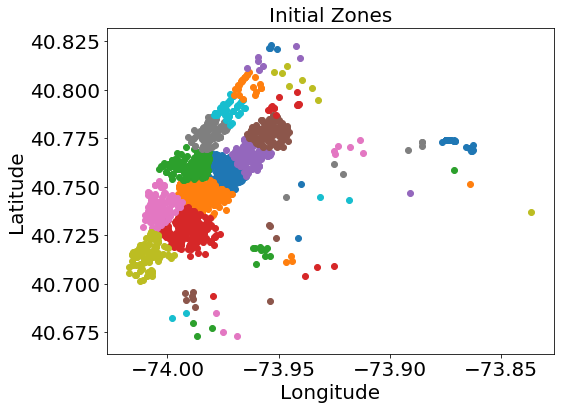

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [38]:
plt.figure(figsize=[8,6])
plt.title("Initial Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
NN = CityZone()
DF_Temp = DF_Train.sample(frac=0.01,random_state= 7299662)
DFLabels, Labelset = NN.MakeZones(DF_Temp,10,plot=True)

print(Labelset)

In [39]:
NN.RankZones(DF_Temp,100,MinRides=5)[0]

,Label,Density,Income
10,10,126.396147,60.497960
5,5,380.511457,59.123288
9,9,166.113652,58.187873


In [40]:
NN.ModelData

,Label,Density,Income
10,10,126.396147,60.497960
5,5,380.511457,59.123288
9,9,166.113652,58.187873
4,4,298.315783,57.423363
11,11,119.286280,56.497599
7,7,308.405497,56.364626
6,6,315.379806,55.474378
8,8,200.380914,55.030741
0,0,550.242458,53.628156
2,2,453.943074,53.226583


1657
1657
1657


Text(0,0.5,'Latitude')

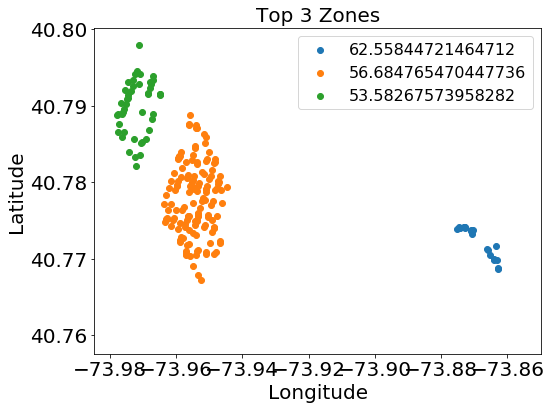

In [41]:
plt.figure(figsize=(8,6))

DF_Temp_Test = DF_Train.sample(frac=0.01)
L, TopLs, Scores = NN.predict(DF_Temp_Test)
for i, lbl in enumerate(TopLs):
    lon = DF_Temp_Test["pickup_longitude"][L==lbl]
    lat = DF_Temp_Test["pickup_latitude"][L==lbl]
    plt.scatter(lon,lat, label = Scores[i])
    plt.legend()
plt.title("Top 3 Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Now try hour by hour

fit the zones to the whole dataset

then subsequent fitting is done on the hour by hour dataset

-this probably is buggy need to make sure that the RankZones function does not rely on points being the same





{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38}


Text(0,0.5,'Latitude')

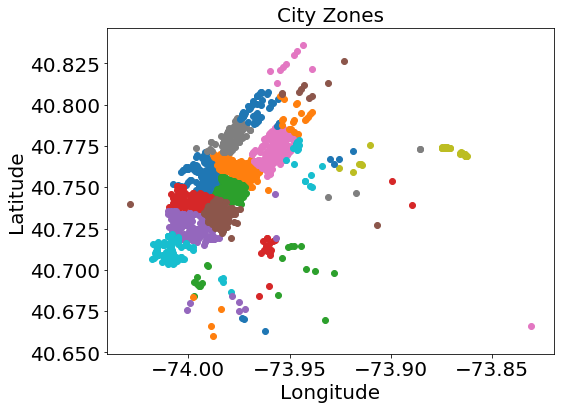

In [42]:
plt.figure(figsize=[8,6])
NN = CityZone()
DFLabels, Labelset = NN.MakeZones(DF_Train.sample(frac=0.01),10)
NewPts =DF_Train.sample(frac=0.01,random_state=2001)

LLs = NN.RankZones(NewPts,100,MinRides=5)[1]
LList = set(LLs)
print(LList)
for l in set(LLs):
    X = NewPts[l==LLs]
    plt.scatter(X["pickup_longitude"],X["pickup_latitude"],label =l)
    
plt.title("City Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [43]:
IncomeModel = CityZone()
DF_Temp = DF_Train.sample(frac=0.1)

PointLabels, ZoneLabels = IncomeModel.MakeZones(DF_Temp,70,plot=False)

ByHr = []

for Hr in range(0,24):
    DF_Train_Now = DF_Temp[DF_Temp["hour"]==Hr]
    print(DF_Train_Now.shape)
    ByHr.append(IncomeModel.RankZones(DF_Train_Now,20))

(643, 22)
(485, 22)
(333, 22)
(223, 22)
(176, 22)
(172, 22)
(347, 22)
(575, 22)
(772, 22)
(816, 22)
(753, 22)
(762, 22)
(851, 22)
(803, 22)
(867, 22)
(798, 22)
(613, 22)
(811, 22)
(971, 22)
(1001, 22)
(1014, 22)
(1012, 22)
(931, 22)
(839, 22)


In [44]:
#Construct a list of actual zones in the top 3

ZoneList = []
CityMeanIncomes = []
FirstMeanIncomes = []
SecondMeanIncomes = []
ThirdMeanIncomes = []

for i in range(0,24):
    print("Hour: {}".format(i))
    print(ByHr[i][0])

    ZoneList.extend(list(ByHr[i][0]["Label"].values))
    CityMeanIncomes.append(DF_Temp["hourly_income_adjusted"][DF_Temp["hour"]==i].mean())
    FirstMeanIncomes.append(ByHr[i][0]["Income"].values[0])
    try:
        SecondMeanIncomes.append(ByHr[i][0]["Income"].values[1])
    except IndexError:
        SecondMeanIncomes.append(np.nan)
    try:
        ThirdMeanIncomes.append(ByHr[i][0]["Income"].values[2])
    except IndexError:
        ThirdMeanIncomes.append(np.nan)
        
ZoneList = list(set(ZoneList))
print(ZoneList)

Hour: 0
   Label     Density     Income
3      3   61.525603  65.088076
0      0  217.884889  63.418182
4      4  195.405157  60.893627
Hour: 1
   Label     Density     Income
3      3   61.677256  73.371385
0      0  180.014462  65.967289
4      5  207.942535  64.581999
Hour: 2
   Label     Density     Income
3      7   88.146089  66.569143
0      1  118.732531  66.141421
4     10  182.101534  63.933868
Hour: 3
   Label     Density     Income
2     11   69.839573  59.970061
0      6  107.442606  58.601641
1      7   63.209988  56.950480
Hour: 4
   Label    Density     Income
2     11  56.294392  68.099794
0      5  86.858035  66.922594
1      7  68.238381  60.838489
Hour: 5
Empty DataFrame
Columns: [Label, Density, Income]
Index: []


IndexError: index 0 is out of bounds for axis 0 with size 0

[58.56619910843673, 61.43985541620558, 62.11957886126778, 62.63675278666523, 66.13915782385311, 70.83053867617126]


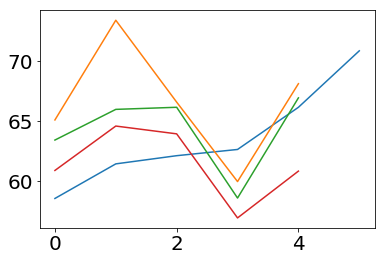

In [45]:
print(CityMeanIncomes)
plt.plot(CityMeanIncomes)
plt.plot(FirstMeanIncomes)
plt.plot(SecondMeanIncomes)
plt.plot(ThirdMeanIncomes)

In [46]:

#Parameters
K = 8
IncomeThreshold = 80
DensityThreshold = 300
MinRides = 60

#Set up stuff

TestDF = DF_Train[["pickup_longitude","pickup_latitude","hourly_income_adjusted","hour"]]#.sample(frac=0.01)
TestDF = TestDF.reset_index(drop=True)
print(TestDF.shape)
kf = KFold(n_splits=K)
Testing = kf.split(TestDF)

#data structures
CityMeanIncome = np.zeros(K)
CityMeanIncomes = np.zeros([24,K])
FirstMeanIncomes = np.zeros([24,K])
SecondMeanIncomes = np.zeros([24,K])
ThirdMeanIncomes = np.zeros([24,K])


for k_i, [train_i, test_i] in enumerate(Testing):

    DF_K = TestDF.loc[train_i]
    DF_K_Test = TestDF.loc[test_i]
    
    #Fit zones
    Model = CityZone()
    Model.MakeZones(DF_K.sample(frac=0.05),IncomeThreshold)
    
    
    
    #Go hour by hour and predict best zones
    CityMeanIncome[k_i] = DF_K["hourly_income_adjusted"].mean()
    
    print(len(DF_K.index))
    
    IncomeByHr = []
    TopZoneByHr = []
    
    for Hr in range(0,24):
        DF_Now = DF_K[DF_K["hour"]==Hr]
        DF_Now_Test = DF_K_Test[DF_K_Test["hour"]==Hr]
        
        CityMeanIncomes[Hr,k_i] = DF_Now["hourly_income_adjusted"].mean() 
        
        print(len(DF_Now.index))
        
        Tops_pred = IncomeModel.RankZones(DF_Now,DensityThreshold,MinRides=MinRides)[0]
        
        #print(Tops_pred)
        #Predict on test data
        Tops = pd.DataFrame()
        lls, lt, income =  IncomeModel.predict(DF_Now_Test)
        #print(lt)
        Tops["Label"] = lt
        
        print(income)
        Tops["Income"] = income
        
                
        TopZoneByHr.append( Tops["Label"].values[0])
        IncomeByHr.append(Tops["Income"].values[0])

        
        FirstMeanIncomes[Hr,k_i] = Tops["Income"].values[0]
        try:
            SecondMeanIncomes[Hr,k_i] = Tops["Income"].values[1]
        except IndexError:
            SecondMeanIncomes[Hr,k_i] = np.nan
        try:
            ThirdMeanIncomes[Hr,k_i] = Tops["Income"].values[2]
        except IndexError:
            ThirdMeanIncomes[Hr,k_i] = np.nan
            
    TopsByHr = pd.DataFrame()
    TopsByHr["Zone"] = TopZoneByHr
    TopsByHr["Income"] = IncomeByHr
    TopsByHr["Hour"] = np.arange(0,24)
    
#To make a plot, what we need out:
#Zone points lat, lon, label
DF_K_Test["label"] = IncomeModel.MeanModel.predict(DF_K_Test[["pickup_longitude","pickup_latitude"]])

#List of highest zone by hour

#List of highest adjust innome for that zone
            
#Above are TopsByHr

#Average over k-fold runs
CityMeanIncome = np.mean(CityMeanIncome)
CityMeanIncomes = np.mean(CityMeanIncomes,axis=1)
FirstMeanIncomes = np.mean(FirstMeanIncomes,axis=1)
SecondMeanIncomes = np.mean(SecondMeanIncomes,axis=1)
ThirdMeanIncomes = np.mean(ThirdMeanIncomes,axis=1)

(165680, 4)
144970
5728
815
815
815
[65.53227085188698, 59.60455853084976, 58.23765783586122]
4216
563
563
563
[68.80233217011121, 62.60931830968087, 65.81508700778302]
3079
430
430
430
[59.31857838287322, 57.15923713484126, 55.623782123536785]
2221
344
344
344
[65.14882286529796, 64.11721557319481, 66.86168707588317]
1648
218
218
218
[65.8566974393422, 66.73805024720504, 59.26575335713402]
1463
181
181
181
[74.02072492314356, 77.05428394789409, 81.28747059598861]
2947
436
436
436
[65.99900830462113, 75.4141645775838, 69.0676729521107]
5250
702
702
702
[83.00883870489211, 60.98485511160997, 54.02150345512924]
6589
967
967
967
[56.02125371240759, 55.045071167756085, 53.75016526626721]
6824
989
989
989
[53.6815696219521, 56.13587661836485, 49.98596776071093]
6551
914
914
914
[48.949062630713364, 55.59666075047218, 58.36101088042709]
6960
989
989
989
[58.288009778876365, 52.991488270018124, 54.13253043884811]
7281
1072
1072
1072
[54.5878085648602, 58.75051579692652, 54.358578760391715]
69

995
995
995
[53.43886581007233, 51.07789506665227, 51.89174537991239]
7271
1082
1082
1082
[57.41739430117733, 55.210710453029236, 57.07602614178103]
6984
1028
1028
1028
[59.541580675406344, 54.74810169279766, 53.503997165362904]
7322
1032
1032
1032
[55.5697184717616, 58.866563031619876, 52.63448342692933]
7015
930
930
930
[53.28849191700862, 56.87224754379997, 52.863440410123204]
5786
791
791
791
[55.59384041191339, 52.609526985450614, 53.67790568083351]
6949
1027
1027
1027
[51.08271990492324, 56.57930344218149, 53.08250660396801]
8776
1321
1321
1321
[56.503447706738264, 56.19512894027469, 58.77118075313616]
8950
1325
1325
1325
[67.6996886346578, 57.174823926560215, 57.01825026522914]
8664
1299
1299
1299
[66.4499382810507, 62.19380367665247, 62.83929117293834]
8340
1186
1186
1186
[66.43954125752, 63.810070221500176, 59.47392977362442]
8190
1104
1104
1104
[63.775166747313065, 62.13484262271811, 55.7232674681861]
7282
1002
1002
1002
[69.4607338106573, 66.85294476278966, 54.22232395898104

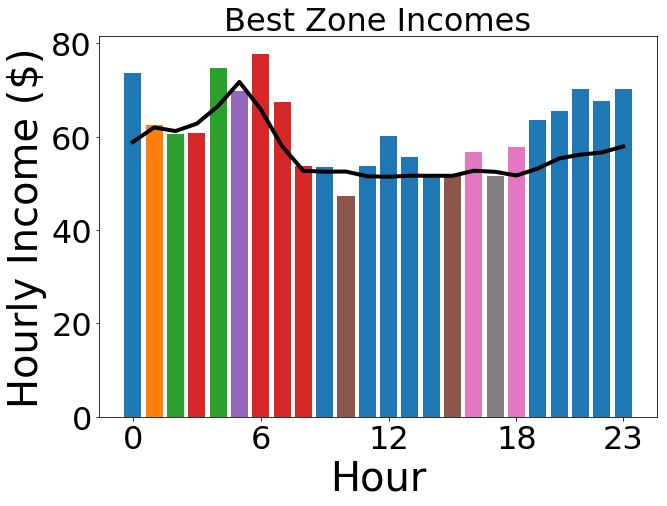

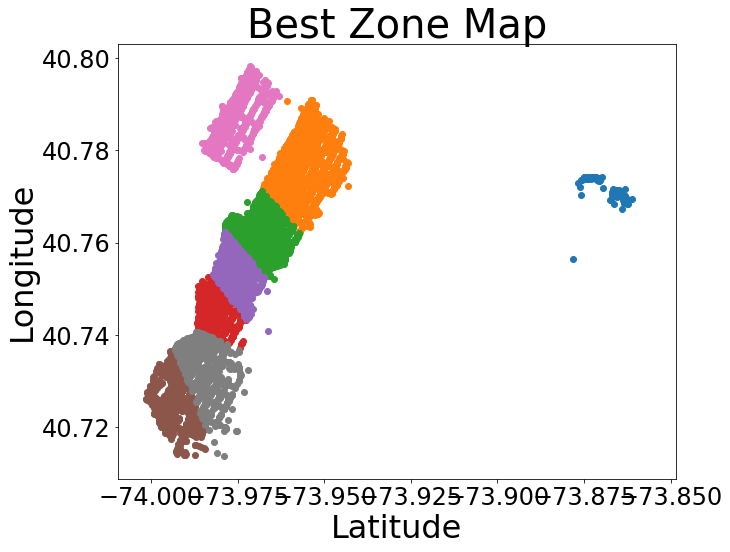

In [47]:
SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 50

plt.rc('font',weight='normal')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*0.8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=[10,7])
for l in TopsByHr["Zone"].unique():
    x = TopsByHr["Hour"][TopsByHr["Zone"]==l]
    y = TopsByHr["Income"][TopsByHr["Zone"]==l]
    plt.bar(x,y,label="Zone: "+str(l))
    plt.gca().set_xticks([0,6,12,18,23])
plt.plot(CityMeanIncomes,linewidth=4, color='black')
plt.title("Best Zone Incomes")
plt.xlabel("Hour")
plt.ylabel("Hourly Income ($)")

SMALL_SIZE = 24
MEDIUM_SIZE = 32
BIGGER_SIZE = 50

plt.rc('font',weight='normal')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*0.8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize =[10,8])
for l in TopsByHr["Zone"].unique():
    DF_Subset = DF_K_Test[l==DF_K_Test["label"]]
    x = DF_Subset["pickup_longitude"]
    y= DF_Subset["pickup_latitude"]
    plt.scatter(x,y)
    plt.title("Best Zone Map",size=40)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")

In [48]:
SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 50

plt.rc('font',weight='normal')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*0.8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[68.90647488 70.58357557 63.40996788 70.0595014  70.92380171 74.84021366
 70.75149302 65.09114025 54.1755677  53.44211062 49.74134838 56.91781517
 58.75205353 56.78519317 54.83589238 51.35440376 57.14518212 53.99970706
 57.14347919 63.11568555 66.72499875 71.13400305 69.97169249 71.96178509]
62.57 vs. 56.64


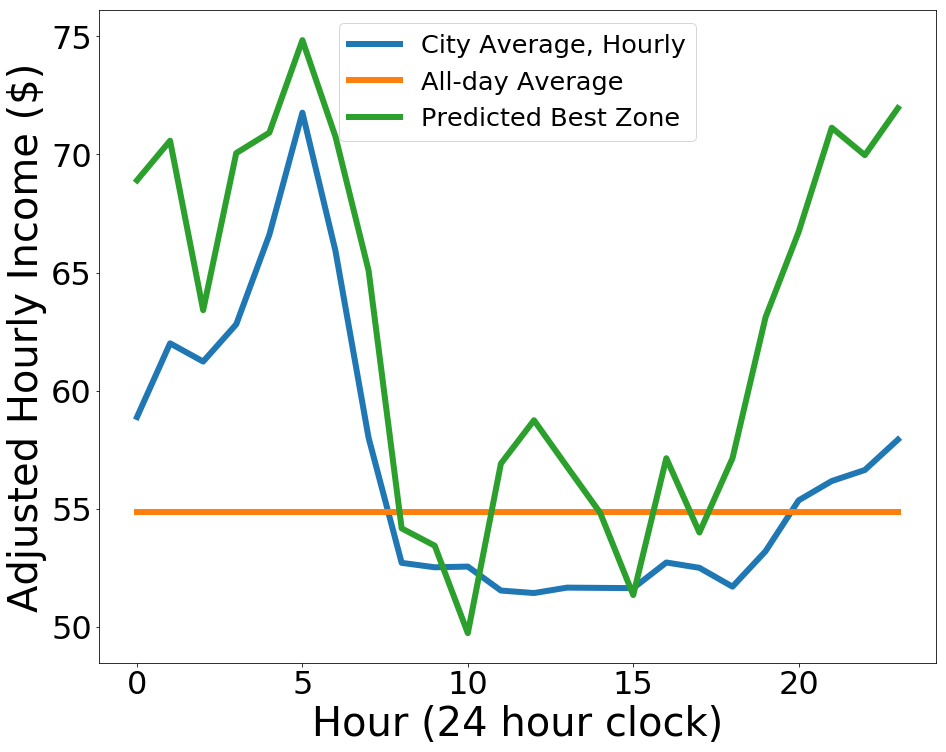

In [49]:
print(FirstMeanIncomes)
plt.figure(figsize=[15,12])

plt.plot(CityMeanIncomes, label="City Average, Hourly",linewidth=6)
plt.plot([CityMeanIncome]*24, label = "All-day Average",linewidth=6)
plt.plot(FirstMeanIncomes, label="Predicted Best Zone",linewidth=6)
#plt.plot(SecondMeanIncomes)

#plt.plot(ThirdMeanIncomes)

plt.ylabel("Adjusted Hourly Income ($)")
plt.xlabel("Hour (24 hour clock)")
plt.legend(loc=9)
print("{0:.4} vs. {1:.4}".format(np.mean(FirstMeanIncomes),np.mean(CityMeanIncomes)))

So it looks like we can get some improvement over the citywide average adjusted income for a taxi's rides, though it is actually rather difficult - note that there are a few hours where the "best zone" is not any better than the average ride. Part of this is probably that rides from low ride density areas pay a premium to make up for the fact that they are so out of the way and require the taxi to come to them, and that brings up the city average.

Still, there are a couple ways to beat the average pretty solidly at certain times - rides from the airport around noon and in the evenings, and then knowing the right places in downtown Manhattan to pick people up in the early morning hours after the bars close

## Other attempt - using contours of income density to locate "high value" areas

Here I'm using a weighted kernel density estimator for something slightly different than it's intended purpose - creating a continuous prediction of density of hourly adjusted income, to try and locate areas that are high traffic and high value

In [50]:
#Code shamelessly borrowed from Till Hoffman
#http://nbviewer.jupyter.org/gist/tillahoffmann/f844bce2ec264c1c8cb5
#https://stackoverflow.com/questions/27623919/weighted-gaussian-kernel-density-estimation-in-python#27623920

import numpy as np
from scipy.spatial.distance import cdist

class weighted_gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method):# and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n



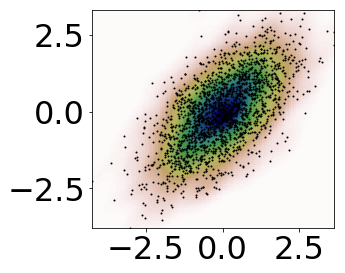

In [51]:
from scipy import stats
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

#Plot the results:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()



(2, 2000)
(2000,)
(2, 2000)
(2000,)


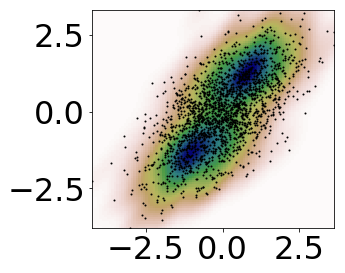

In [52]:
print(values.shape)
#weights = np.ones(values[:,0].shape)
weights = 0.1+abs(m2.copy())
print(weights.shape)

print(values.shape)
print(weights.shape)
kernel2 = weighted_gaussian_kde(values,weights=weights)
Z2 = np.reshape(kernel2(positions).T, X.shape)

#Plot the results:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z2), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()


The weighting looks like it works correctly: Weighting by y-value seems to have depressed the values near y=0.

(2, 16568)
(16568,)
[ 428.81946194    6.58702345  550.90819877 ...  283.04410785 1081.00096002
  204.94925667]
[0.39186499 0.00601937 0.50343245 ... 0.25865215 0.98784329 0.1872873 ]


Text(0.5,1,'Weighted KDE')

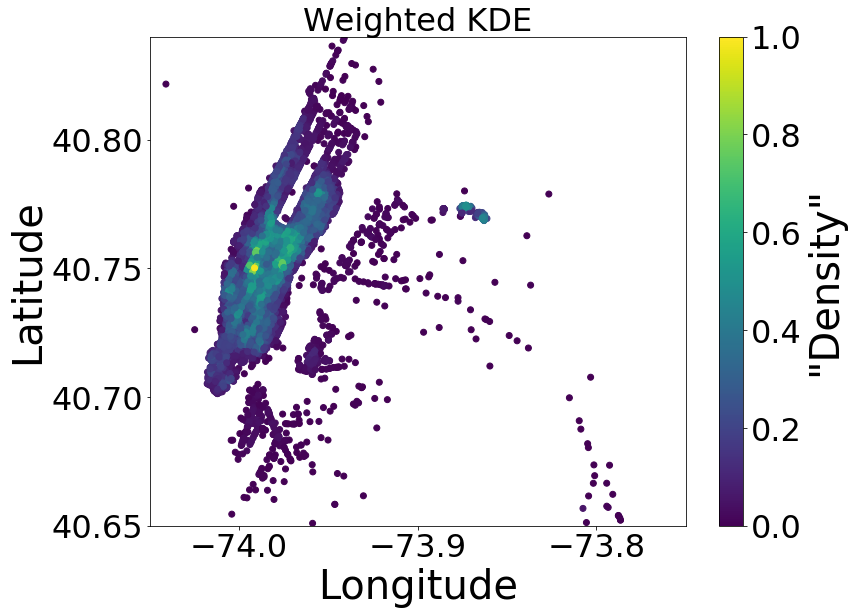

In [53]:
DF_Train2 = DF_Train.sample(frac=0.1)
X = DF_Train2[["pickup_longitude","pickup_latitude"]].values.T
W = np.maximum(0,DF_Train2["hourly_income_adjusted"].values)



print(X.shape)
print(W.shape)

KDE_Model = weighted_gaussian_kde(X,weights=W,bw_method = 0.06)
X_test = DF1[["pickup_longitude","pickup_latitude","hourly_income_adjusted"]].sample(frac=0.01)
yp = KDE_Model(X_test[["pickup_longitude","pickup_latitude"]].values.T)

print(yp)
Huh = (np.maximum(0,yp/np.amax(yp)))
print(Huh)
plt.figure(figsize=(12,9))
plt.scatter(X_test["pickup_longitude"],X_test["pickup_latitude"],c=Huh)
plt.xlim((LonMin,LonMax))
plt.ylim((LatMin,LatMax))
plt.colorbar(label='"Density"')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted KDE")


Text(0.5,1,'Weighted KDE, Masked')

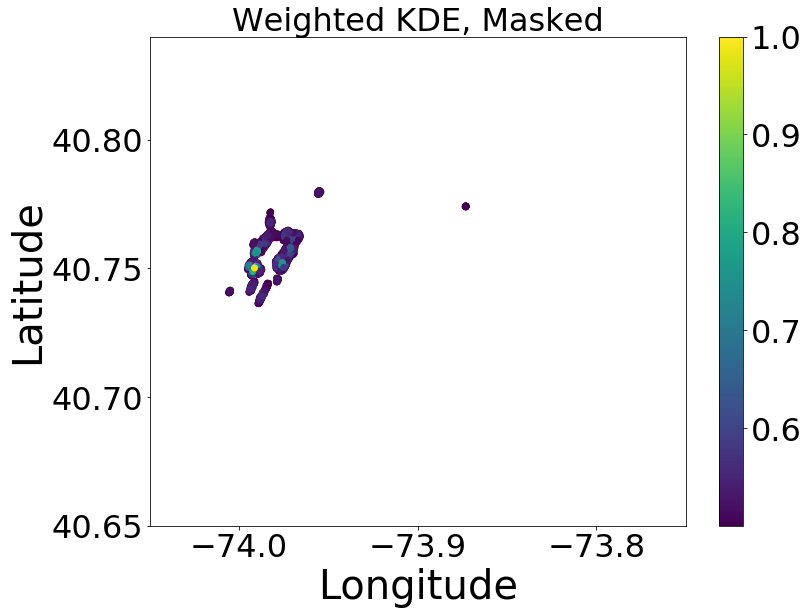

In [54]:
plt.figure(figsize=(12,9))

Huh = (np.maximum(0,yp/np.amax(yp)))
Threshold = 0.5
Mask = Huh>Threshold
X_masked = X_test[Mask]
plt.scatter(X_masked["pickup_longitude"],X_masked["pickup_latitude"],c=Huh[Mask])
plt.xlim((LonMin,LonMax))
plt.ylim((LatMin,LatMax))
plt.colorbar()

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted KDE, Masked")


In [55]:
DF1["hourly_income_adjusted"].mean()

54.81937732891844

Pick a point, pick

In [56]:
X_masked["hourly_income_adjusted"].mean()

53.28541158640375

 Density beats income per ride

In [57]:
Threshold = 0.6
Mask = Huh>Threshold
X_masked = X_test[Mask]
X_masked["hourly_income_adjusted"].mean()

53.600925637340495

What now? Weight the income metric more highly?



Text(0.5,1,'Weighted KDE, Exponent=2')

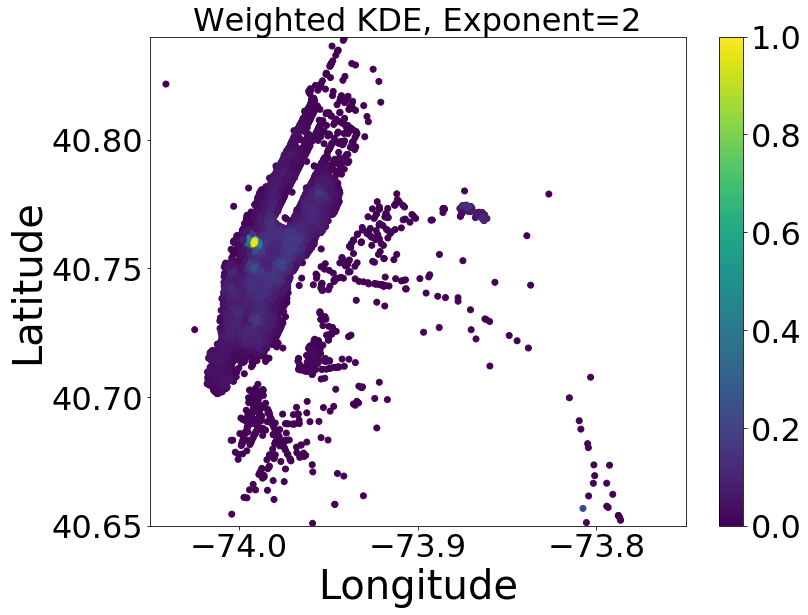

In [58]:
PolyFact = 2
plt.figure(figsize=(12,9))
KDE_Model_HeavyWeight = weighted_gaussian_kde(X,weights=W**PolyFact,bw_method = 0.06)
yp = KDE_Model_HeavyWeight(X_test[["pickup_longitude","pickup_latitude"]].values.T)

HuhHW = (np.maximum(0,yp/np.amax(yp)))
plt.figure(figsize=(12,9))
plt.scatter(X_test["pickup_longitude"],X_test["pickup_latitude"],c=HuhHW)
plt.xlim((LonMin,LonMax))
plt.ylim((LatMin,LatMax))
plt.colorbar()

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted KDE, Exponent=2")


52.76468488154823


Text(0.5,1,'Weighted KDE,Pow=2, Masked')

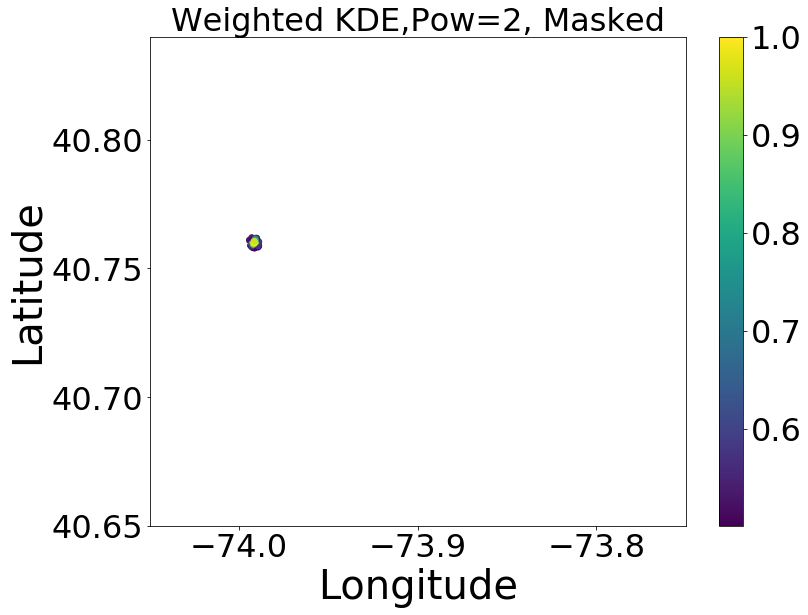

In [59]:
plt.figure(figsize=[12,9])

Threshold = 0.5

Mask = HuhHW>Threshold
X_masked = X_test[Mask]
plt.scatter(X_masked["pickup_longitude"],X_masked["pickup_latitude"],c=HuhHW[Mask])
plt.xlim((LonMin,LonMax))
plt.ylim((LatMin,LatMax))
plt.colorbar()

print(X_masked["hourly_income_adjusted"].mean())

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weighted KDE,Pow=2, Masked")


Still doesn't beat the city average... Low density rides are too profitable!